# Computer Assignment 5 a) -- Group 2
* Ali Bemani
* Martin Hellkvist

This document is structured like this:
* Problem setup
    * Describes the problem setup, cost functions and gradients
    * Preprocessing of data
    * Robustifications
* Summary of Results
* Implementation
The results and implementations for 5b) and c) is included in a separate file ``CA-G2-5-bc.ipynb``.

# Problem setup
The MNIST dataset is used to train a binary SVM classifier.
The dataset is restricted to only examples with labels "0" and "1", this way we only have two classes, and can use a binary SVM classifier.
The multiclass SVM classifier is an extension to this, but we ignore it for the sake of simplicity.

We transform the labels so that "0" is assigned -1, and "1" is assigned +1.
This enables us to define the objective function as
$$ L(w) = \frac{1}{N} \sum_{i\in [N]} L_i(w) + \lambda ||w||_2^2, $$
$$ L_i(w) = \max(0, 1 - y_i w^T x_i) $$
and we use the following subgradient for gradient descent:
$$ \partial L_i(w) = -y_i x_i, ~~\text{if}~~ 1 - y_i w^T x_i > 0,~~ \text{otherwise} ~~ \partial L_i(w) = 0 $$
so that the subgradient for $L$ becomes
$$ \partial L(w) = \frac{1}{N} \sum_{i\in[N]} \partial L_i(w) + 2\lambda w $$

## Preprocessing of data
After removing the examples with labels not "0" or "1" we do some preprocessing of the data.
Originally each example has the label together with an 28 by 28 array of pixels with values from 1 to 255.
We reorganize it so that each of these arrays is a $28^2=784$ vector scaled by $1/255$.
This scaling rescales the problem, and can give nicer numerical properties.
Then we append a new entry into each vector of value $1$, which enables the transformation $w^T x_i$ to be affine, rather than strictly linear.

## Distribution over workers
We then split the input data into a python list ``X`` with 10 elements.
Each element is a numpy array of shape ``(N,785)``, where ``N`` is the number of data used for training in each worker.
We also have the list ``Y`` which is also of 10 elements, but with numpy arrays of shape ``(N,1)``.

## Computation of gradients
The (sub)gradients are then computed in a distributed fashion like this
* For each worker ``i = 1, ..., 10``
    * ``g[i] = compute_gradient(w, X[i], Y[i])``
    
Then the parameters at the master is computed like ``w = w - alpha/N*(g[1] + ... + g[10])``.


# Summary of results
We compute the number of signal exchanges as this:
* Node 10 collects 9 gradients from the other workers (9 exchanges) and then broadcasts the computed parameter vector (1 exchange).
This totalts to 10 signal exchanges per iteration $t$: $T=10t$.

We first used step sizes $\alpha$ similar to what we used in CA4, around 0.03.
This turned out to be much smaller than what is needed for this experiment. 
The noise in CA4 made it more sensitive, thus a smaller stepsize was needed.

A grid search over $\alpha$ from $1$ to $9$ shows that $\alpha=7$ gives the best results of these:
* Decentralized Gradient Descent $\alpha=7$:
    * 1031 our of 1031 predictions,
    * 9 iterations,
    * 90 signaling exchanges.

In [2]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [3]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0, we will only use a binary SVM classifier.

In [4]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

-1.0


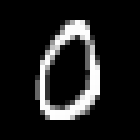

In [5]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

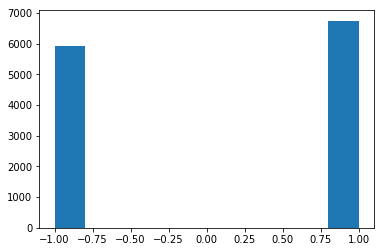

In [6]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

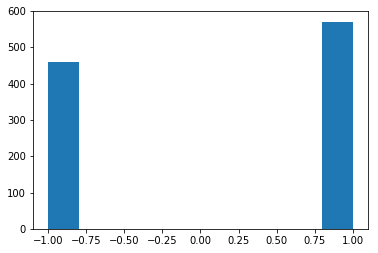

In [7]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [12]:
np.random.seed(0)
N_train = train_data.shape[0]
print(N_train)
N_data = test_data.shape[0]
N_workers = 10
N_train = N_train - N_train % N_workers
print(N_train)

indexes_ = np.random.choice(N_train, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

12665
12660


In [13]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Gradient Solvers
The local function in worker $i$ to minimize is

$$ f_i(w) = \frac{1}{|D_i|} \sum_{(x,y)\in D_i} (y - w^T x)^2 $$

which has the gradient 

$$ \nabla f_i(w) =  \frac{2}{|D_i|} \sum_{(x,y)\in D_i} x (w^T x - y)  $$

### Compute Grad

In [14]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [15]:
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1 - Y * (X @ w) # (N,1)
    L[L < 0] = 0
    return L

### Cost

In [16]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [17]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [18]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Def solver

In [32]:
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD",
           mini_batch = 100, mem=False, return_cost=False, verbose=True, seed=-1, p_val=0, R_val=0):
    
    N_workers = len(X)
    dw = w.shape[0]
    
    noise_std = R_val**0.5
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
    if return_cost:
        cost_[0] = accuracy(w, X_test, Y_test)
    
    if (optimizer == "GD"):
        g_ = np.zeros(shape=(dw, N_workers))
        numitersstop = num_iters
        for i in range(num_iters):
            for worker_i in range(N_workers):
#                 set_trace()
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_) \
                        + np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g/N_workers # GD update
            
            gnorm = np.linalg.norm(g)
            if gnorm <= epsilon:
                print("Stopped on espilionis gradientus size")
                numitersstop = i
                break
            
            if return_cost:
                cost_[i+1] = accuracy(w, X_test, Y_test)
                
        if (verbose):
            print("GD: Number of iterations: ", numitersstop, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
            
    return cost_, w

# Run SVM solver on data
With step size $\alpha = 1$ 
the algorithm converges after iteration 173 with 1031 out of 1031 correct predictions.

With step size $\alpha = 2$ 
the algorithm converges after iteration 84 with 1031 out of 1031 correct predictions.

With step size $\alpha =5$ 
the algorithm converges after iteration 11 with 1031 out of 1031 correct predictions.

With step size $\alpha = 6$ 
the algorithm converges after iteration 10 with 1031 out of 1031 correct predictions.

With step size $\alpha = 7$ 
the algorithm converges after iteration 9 with 1031 out of 1031 correct predictions.
70 exchanges

$\alpha=8$ does not improve results, the accuracy peaks early and then decreases.

In [64]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,1)
alpha = 7
num_iters = 100
lambda_ = 0
epsilon = 0
time1 = time.time()
cost_GD, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD",
           mini_batch = 100, mem=False, return_cost=True, verbose=True, seed=-1, p_val=0, R_val=0)
time2 = time.time()
print("Runtime GD num_iters=", time2-time1)

GD: Number of iterations:  100 / 100
GD: final norm:  0.04416770164945651
Runtime GD num_iters= 7.509917259216309


final cost 1.0
final acc: 1031.0 of 1031


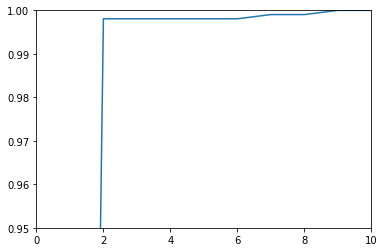

In [66]:
plt.plot(cost_GD)
print("final cost", cost_GD[-1])
plt.ylim(0.95,1)
plt.xlim(0,10)
acc_final = accuracy(w_out, X_test, y_test)
print("final acc:", acc_final*N_test, "of", N_test)